In [37]:
#we call the packages we will need in this project
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image, ImageOps
from matplotlib import image
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from keras.regularizers import l1, l2
import seaborn as sns

import sklearn.preprocessing as skp
import random
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.initializers import HeNormal
from tensorflow import keras

### Upload the data

In [38]:
#we upload the data
!wget  https://neovision-public.s3.eu-west-3.amazonaws.com/data_ia/v2/public_data.zip

--2022-11-19 19:35:16--  https://neovision-public.s3.eu-west-3.amazonaws.com/data_ia/v2/public_data.zip
Resolving neovision-public.s3.eu-west-3.amazonaws.com (neovision-public.s3.eu-west-3.amazonaws.com)... 52.95.155.98
Connecting to neovision-public.s3.eu-west-3.amazonaws.com (neovision-public.s3.eu-west-3.amazonaws.com)|52.95.155.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37524473 (36M) [application/zip]
Saving to: ‘public_data.zip.1’

public_data.zip.1   100%[===================>]  35.79M  18.4MB/s    in 1.9s    

2022-11-19 19:35:19 (18.4 MB/s) - ‘public_data.zip.1’ saved [37524473/37524473]



In [39]:
!rm -r data
!mkdir data
!unzip -q public_data.zip -d ./data

### Read and preprocess the data

In [40]:
TRAIN_DIR = "./data/train.csv"
TEST_DIR = "./data/test.csv"

In [41]:
train = pd.read_csv(TRAIN_DIR)
test = pd.read_csv(TEST_DIR)

In [42]:
#let's visualise our data
train.head()

,index,char,image,mask
0,0,c,train/00000.image.jpg,train/00000.mask.jpg
1,1,t,train/00001.image.jpg,train/00001.mask.jpg
2,2,w,train/00002.image.jpg,train/00002.mask.jpg
3,3,f,train/00003.image.jpg,train/00003.mask.jpg
4,4,2,train/00004.image.jpg,train/00004.mask.jpg


In [43]:
#we extract the labels
y_train = train['char']
x_train = train.drop('char', axis = 1)
x_test = test

In [44]:
x_train.head()

,index,image,mask
0,0,train/00000.image.jpg,train/00000.mask.jpg
1,1,train/00001.image.jpg,train/00001.mask.jpg
2,2,train/00002.image.jpg,train/00002.mask.jpg
3,3,train/00003.image.jpg,train/00003.mask.jpg
4,4,train/00004.image.jpg,train/00004.mask.jpg


In [45]:
y_train.head()

0    c
1    t
2    w
3    f
4    2
Name: char, dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


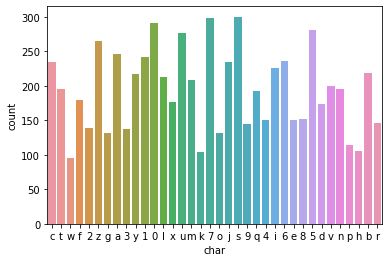

In [46]:
g = sns.countplot(y_train)

In [47]:
print("we have " + str(len(x_train)) + " data in the trainig set")
print("we have " + str(len(x_test)) + " data in the test set")

we have 7000 data in the trainig set
we have 3000 data in the test set


In [48]:
def vizualise(index):
    """
    This function visualizes an image and its mask
    index : the index of the image to visualize
    """
    path_image = './data/'  + x_train.loc[index, 'image']   #On peut même utiliser x_train.loc[0].image
    path_mask = './data/'  + x_train.loc[index, 'mask']
    fig, (ax1, ax2) = plt.subplots(1, 2)
    image = Image.open(path_image)
    image = image.resize((64, 64))
    mask = Image.open(path_mask)
    mask = mask.resize((64, 64))
    fig.suptitle('Example Number ' + str(index) + " of the data set")
    ax1.imshow(image)
    ax2.imshow(mask)

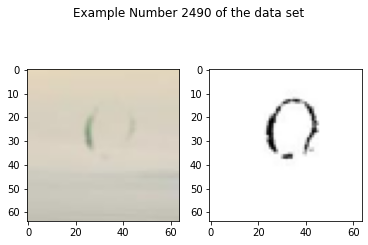

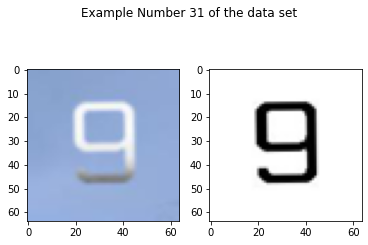

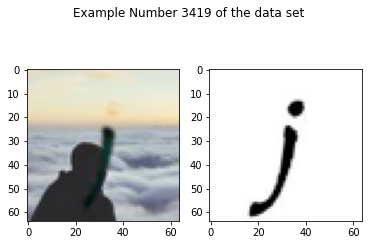

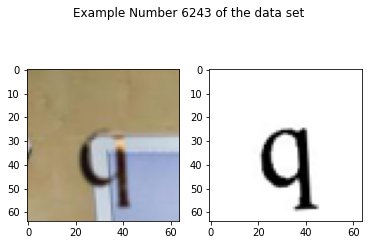

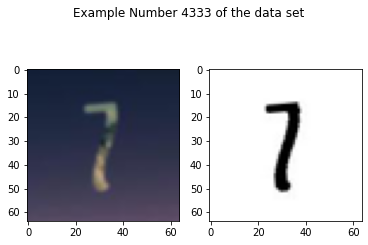

In [49]:
#Show random images
random_images = [random.randint(0, 7001) for _ in range(5)]
for index in random_images:
    vizualise(index)

The data we have is composed of two images : a noisy image containing a character [0-z] and the mask which contains just the character without any noise. But the problem is, the test dataset contains just the noisy images. Then, the idea is first to know how to generate the masks of a noisy image which will be used for the character recognition.
One of the most known architecture is called U-NET. To know more about it : check https://arxiv.org/pdf/1505.04597v1.pdf

In [50]:
def preprocess(x_train):
    """
    In our features we just have the path of images
    In this function we will :
    - open images and transform them to some matrix
    - normalize the data
    - transform the mask to grayscale image
    """
    images =  []
    masks = []
    for i in range(len(x_train)):
        path_image = './data/'  + x_train.loc[i, 'image']
        path_mask = './data/'  + x_train.loc[i, 'mask']
        image = Image.open(path_image)
        image = image.resize((64, 64))
        mask = ImageOps.grayscale((Image.open(path_mask)))
        mask = mask.resize((64, 64))
        images.append(np.array(image)/255)
        masks.append(np.array(mask)/255)
    return images, masks

In [51]:
#get the images after resizing and normalizing
data = preprocess(x_train)
images = np.array(data[0])
masks = np.array(data[1])

In [52]:
print(f"the shape of the images after preprocessing is : {images.shape}")
print(f"the shape of the masks after preprocessing is : {masks.shape}" )

the shape of the images after preprocessing is : (7000, 64, 64, 3)
the shape of the masks after preprocessing is : (7000, 64, 64)


In [53]:
def one_hot_encoder(y_train):
    """
    transform our labels to an array containig 0 and 1 in the representing the character 
    """
    classes = "0123456789abcdefghijklmnopqrstuvwxyz"
    y_train_encoded = []
    for y in y_train:
        y_encoded = [0 for _ in range(len(classes))]
        index = classes.index(y)
        y_encoded[index] = 1
        y_train_encoded.append(y_encoded)
    return y_train_encoded

In [54]:
y_train_encoded = np.array(one_hot_encoder(y_train))

In [55]:
#let's check if the one hot encoder works well
random_labels = [random.randint(0, 7001) for _ in range(5)]
for idx in random_labels:
    print(f"{y_train[idx]} encoded : {y_train_encoded[idx]}")

2 encoded : [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
s encoded : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
n encoded : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
z encoded : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
c encoded : [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## **Segmentation architecture U-NET:**

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

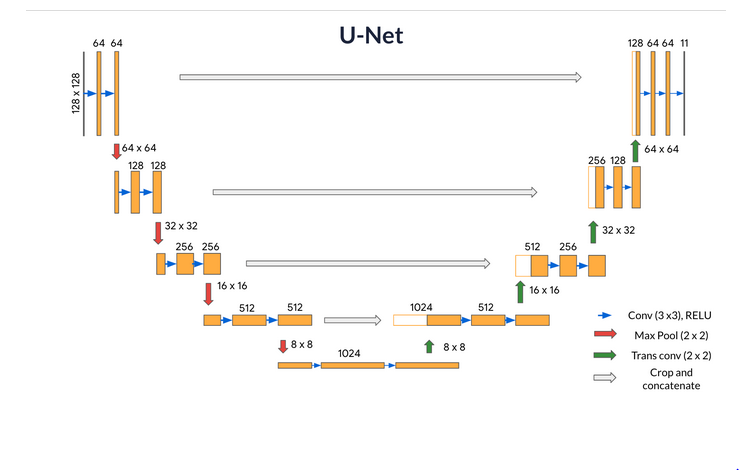

In [56]:
def down_sample(inputs, n_filters = 16, max_pooling = True):
    conv1 = Conv2D(n_filters, 3, padding= "same", activation='relu', kernel_initializer=HeNormal())(inputs)
    conv2 = Conv2D(n_filters, 3, padding= "same", activation='relu', kernel_initializer=HeNormal())(conv1)
    if max_pooling:
        conv3 = MaxPooling2D(pool_size=(2, 2))(conv2)
        return conv2, conv3
    return conv2

In [57]:
def up_sample(inputs, down, n_filters = 16):
    conv1 = Conv2DTranspose(n_filters, 3, padding='same', strides=(2,2), activation="relu", kernel_initializer=HeNormal())(inputs)
    merge = concatenate([conv1, down], axis=3)
    conv2 = Conv2D(n_filters, 3, padding='same', activation="relu", kernel_initializer=HeNormal())(merge)
    conv3 = Conv2D(n_filters, 3, padding='same', activation="relu", kernel_initializer=HeNormal())(conv2)
    return conv3

In [58]:
def segmentation_model(input_shape = (128, 128, 3), n_classes = 1):

    inputs = Input(input_shape)
    #downsampling
    concat1, conv1 = down_sample(inputs, 16) 
    concat2, conv2 = down_sample(conv1, 16 * 2) 
    concat3, conv3 = down_sample(conv2, 16 * 4) 
    concat4, conv4 = down_sample(conv3, 16 * 8) 

    bottle_neck = down_sample(conv4, 16 * 8, max_pooling=False)

    #upsampling
    up4 = up_sample(bottle_neck, concat4, 16 * 8) 
    up3 = up_sample(up4, concat3, 16 * 4) 
    up2 = up_sample(up3, concat2, 16 * 2) 
    up1 = up_sample(up2, concat1, 16) 


    outputs = Conv2D(n_classes, kernel_size = 1, padding = "same", activation="sigmoid")(up1)

    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [59]:
model = segmentation_model((64, 64, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [60]:
model.compile(optimizer='adam',
              loss = "binary_crossentropy",
              metrics=['accuracy'])

In [61]:
EPOCHS = 30
BATCH_SIZE = 32

In [62]:
model_history = model.fit(x = images, y = masks, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.2)

Epoch 1/30
175/175 [==============================] - 6s 26ms/step - loss: 0.2070 - accuracy: 0.8366 - val_loss: 0.1668 - val_accuracy: 0.8423
Epoch 2/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1472 - accuracy: 0.8470 - val_loss: 0.1314 - val_accuracy: 0.8491
Epoch 3/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1194 - accuracy: 0.8528 - val_loss: 0.1168 - val_accuracy: 0.8522
Epoch 4/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1056 - accuracy: 0.8558 - val_loss: 0.1037 - val_accuracy: 0.8554
Epoch 5/30
175/175 [==============================] - 4s 22ms/step - loss: 0.0966 - accuracy: 0.8578 - val_loss: 0.0975 - val_accuracy: 0.8564
Epoch 6/30
175/175 [==============================] - 4s 22ms/step - loss: 0.0883 - accuracy: 0.8596 - val_loss: 0.0953 - val_accuracy: 0.8580
Epoch 7/30
175/175 [==============================] - 4s 22ms/step - loss: 0.0835 - accuracy: 0.8607 - val_loss: 0.0877 - val_accuracy: 0.8590

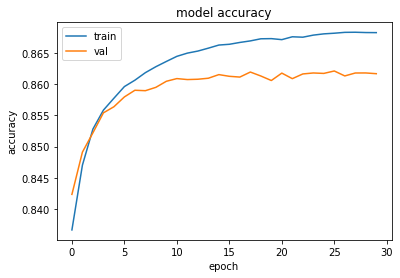

In [63]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
def preprocess_test(x_test):
    """
    In our features we just have the path of images
    In this function we will :
    - open images and transform them to some matrix
    - normalize the data
    - transform the mask to grayscale image
    """
    images =  []
    for i in range(len(x_test)):
        path_image = './data/'  + x_test.loc[i, 'image']
        image = Image.open(path_image)
        image = image.resize((64, 64))
        images.append(np.array(image)/255)
    return images

In [65]:
x_test = preprocess_test(x_test)

In [66]:
masks_predicted = model.predict(np.array(x_test))

#### Visualizing some test images and their predicted masks

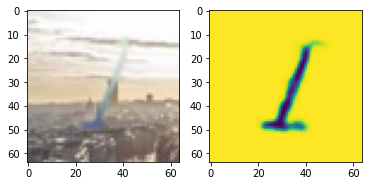

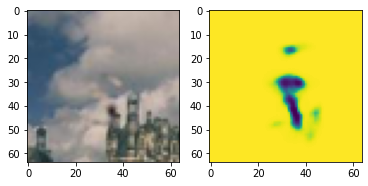

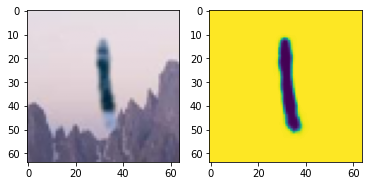

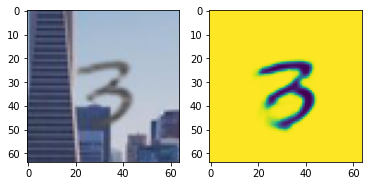

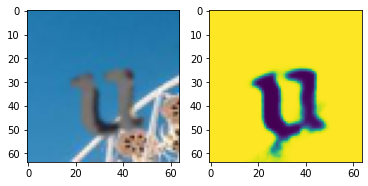

In [67]:
random_images = [random.randint(0, 3001) for _ in range(5)]
for idx in random_images:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x_test[idx])
    ax2.imshow(masks_predicted[idx])

Now after generating the masks of the test set, it will be easier to predict the character based on a CNN model. To do so, we will try two approaches. A home made CNN architecture and a model based on transfert learning.

# **Character recongnition**

### **CNN from scratch :** 

In [68]:
model1= Sequential()

model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (64, 64, 1)))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', ))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(3,3)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(64, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(36, activation = "softmax", kernel_regularizer=regularizers.l2(0.01)))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 21, 21, 64)        3

In [69]:
#optimizer = RMSprop(lr = 0.01, rho = 0.9, epsilon = 1e-08, decay= 0.0)
#optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999 )
#optimizer = SGD(lr = 0.01)
model1.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ['accuracy'])

In [70]:
masks_reshaped = np.reshape(masks, (7000, 64, 64, 1))

In [71]:
masks_reshaped.shape

(7000, 64, 64, 1)

In [72]:
history = model1.fit(masks_reshaped, y_train_encoded, epochs = 50, batch_size = 100, validation_split = 0.2)

Epoch 1/50
56/56 [==============================] - 6s 65ms/step - loss: 7.2535 - accuracy: 0.1230 - val_loss: 9.0177 - val_accuracy: 0.0386
Epoch 2/50
56/56 [==============================] - 3s 59ms/step - loss: 5.1820 - accuracy: 0.3396 - val_loss: 8.1844 - val_accuracy: 0.0386
Epoch 3/50
56/56 [==============================] - 3s 61ms/step - loss: 3.8653 - accuracy: 0.5039 - val_loss: 6.6051 - val_accuracy: 0.0429
Epoch 4/50
56/56 [==============================] - 3s 59ms/step - loss: 3.0724 - accuracy: 0.6027 - val_loss: 5.8691 - val_accuracy: 0.0436
Epoch 5/50
56/56 [==============================] - 3s 61ms/step - loss: 2.5472 - accuracy: 0.6736 - val_loss: 5.7643 - val_accuracy: 0.0429
Epoch 6/50
56/56 [==============================] - 3s 61ms/step - loss: 2.2089 - accuracy: 0.7200 - val_loss: 5.4638 - val_accuracy: 0.0550
Epoch 7/50
56/56 [==============================] - 3s 61ms/step - loss: 2.0013 - accuracy: 0.7479 - val_loss: 4.9995 - val_accuracy: 0.1043
Epoch 8/50
56

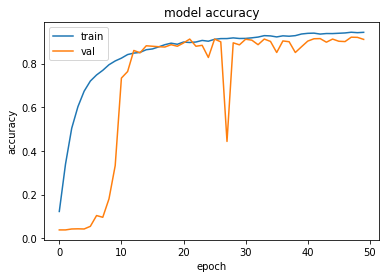

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Let's get the predictions of the test dataset

In [74]:
y_predicted = model1.predict(masks_predicted)
y_predicted = np.argmax(y_predicted, axis = 1)

In [77]:
CLASSES = "0123456789abcdefghijklmnopqrstuvwxyz"
predicted_labels = []
for y in y_predicted:
    predicted_labels.append(CLASSES[y])

#### Let's vizualise some random predictions

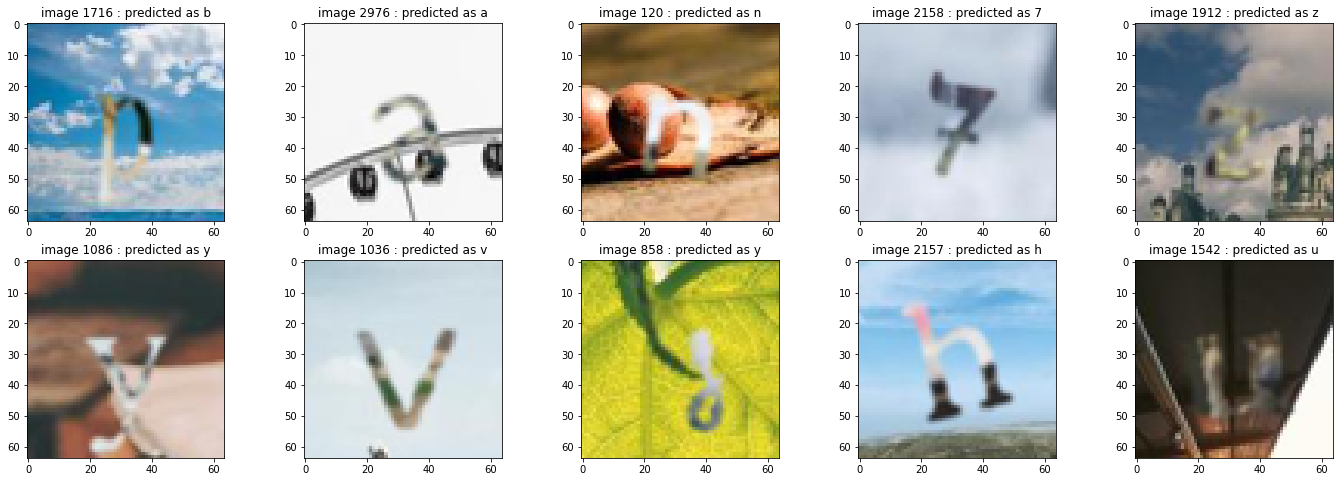

In [91]:
random_images = [random.randint(0, 3001) for _ in range(10)]
fig, axs = plt.subplots(2, 5, figsize =(24,8))
for i, idx in enumerate(random_images):
    axs[i // 5, i % 5].imshow(x_test[idx])
    axs[i // 5, i % 5].set_title(f"image {idx} : predicted as {predicted_labels[idx]}")

### **Transfert Learning :** 

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [80]:
#Since resnet model takes the images with 3 channels, 
#we have to reshape the masks from 1 channel to 3 channels 

#Training set
reshaped_masks = []
for image in masks:
    reshaped_masks.append(np.stack((image,)*3, axis=-1))
reshaped_masks = np.array(reshaped_masks)

#Test set
masks_predicted = masks_predicted.reshape(3000, 64, 64)
reshaped_test_masks = []
for image in masks_predicted:
    reshaped_test_masks.append(np.stack((image,)*3, axis=-1))

Let's vizualise one of the images to make sure the reshape is well made.

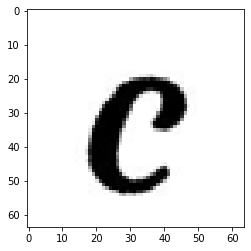

In [81]:
plt.imshow(reshaped_masks[0])

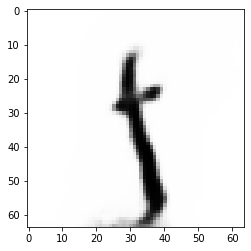

In [83]:
plt.imshow(reshaped_test_masks[0])

In [93]:
#Preprocess the data
image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(reshaped_masks, 
                                 y_train_encoded,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(reshaped_masks,
                                 y_train_encoded,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')

In [116]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (64, 64, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=40)

Epoch 1/40
175/175 [==============================] - 19s 92ms/step - loss: 2.0721 - accuracy: 0.4529 - val_loss: 5.3602 - val_accuracy: 0.0229
Epoch 2/40
175/175 [==============================] - 15s 86ms/step - loss: 0.8305 - accuracy: 0.7625 - val_loss: 4.3137 - val_accuracy: 0.0229
Epoch 3/40
175/175 [==============================] - 15s 88ms/step - loss: 0.5687 - accuracy: 0.8302 - val_loss: 4.1685 - val_accuracy: 0.0229
Epoch 4/40
175/175 [==============================] - 15s 83ms/step - loss: 0.4681 - accuracy: 0.8618 - val_loss: 3.7884 - val_accuracy: 0.0329
Epoch 5/40
175/175 [==============================] - 16s 90ms/step - loss: 0.3724 - accuracy: 0.8843 - val_loss: 3.6871 - val_accuracy: 0.0279
Epoch 6/40
175/175 [==============================] - 15s 84ms/step - loss: 0.3566 - accuracy: 0.8895 - val_loss: 3.7594 - val_accuracy: 0.0221
Epoch 7/40
175/175 [==============================] - 16s 91ms/step - loss: 0.3024 - accuracy: 0.9057 - val_loss: 3.6508 - val_accuracy:

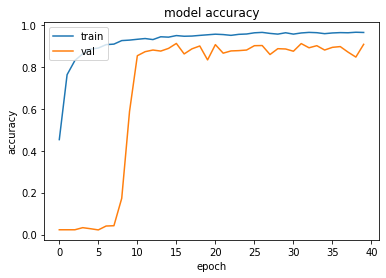

In [119]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()